<a href="https://colab.research.google.com/github/Art-Rock-Climber/Elbrus-tour-searches-analysis/blob/main/Elbrus_tour_searches_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm
from scipy.stats import kendalltau

url = "https://docs.google.com/spreadsheets/d/1nMT0ijXcX4ZFjB4S9BuKSA1tRUiafs2A/export?format=xlsx"
df = pd.read_excel(url)

df.columns = ['date', 'requests', 'percentage', 'description']
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

ts_data = df['requests']
ts_data = ts_data.asfreq('W-MON')

print(ts_data.head(5))
print("\nОсновная информация о данных:")
print(f"Период: {ts_data.index[0]} - {ts_data.index[-1]}")
print(ts_data.describe())

date
2018-10-01 02:00:16    609
2018-10-08 02:00:16    628
2018-10-15 02:00:16    585
2018-10-22 02:00:16    576
2018-10-29 02:00:16    627
Freq: W-MON, Name: requests, dtype: int64

Основная информация о данных:
Период: 2018-10-01 02:00:16 - 2025-10-27 02:00:16
count     370.000000
mean     1024.762162
std       423.458400
min       177.000000
25%       718.000000
50%      1028.000000
75%      1298.000000
max      2635.000000
Name: requests, dtype: float64


АНАЛИЗ АВТОКОРРЕЛЯЦИИ: Число запросов 'эльбрус тур'


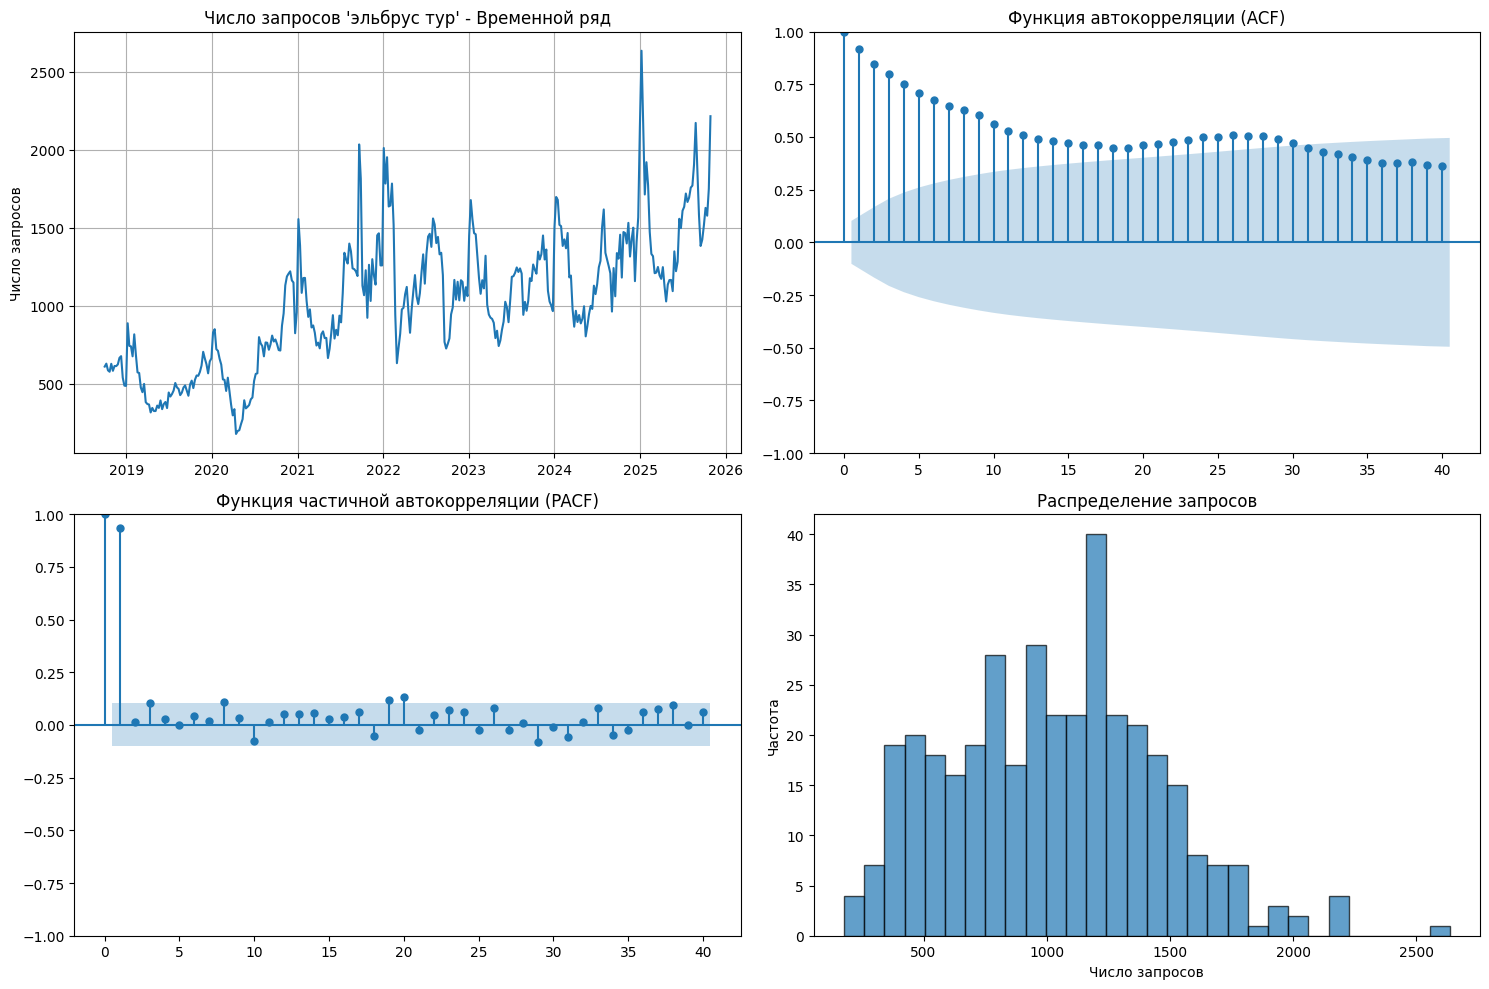

ТЕСТ ДАРБИНА-ВАТСОНА:
   Дарбин-Ватсон: 0.0211 → СИЛЬНАЯ ПОЛОЖИТЕЛЬНАЯ автокорреляция

ТЕСТ ЛЬЮНГА-БОКСА:
   Лаг 5: p-value = 0.000000 → ЕСТЬ автокорреляция ***
   Лаг 10: p-value = 0.000000 → ЕСТЬ автокорреляция ***
   Лаг 20: p-value = 0.000000 → ЕСТЬ автокорреляция ***

КОЭФФИЦИЕНТЫ АВТОКОРРЕЛЯЦИИ:
   Лаг  1:  0.9266
   Лаг  2:  0.8606
   Лаг  3:  0.8140
   Лаг  4:  0.7718
   Лаг  8:  0.6511
   Лаг 12:  0.5481


In [ ]:
def check_autocorrelation(series, title):
    print(f"АНАЛИЗ АВТОКОРРЕЛЯЦИИ: {title}")

    # 1. Графики
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Исходные данные
    axes[0, 0].plot(series)
    axes[0, 0].set_title(f'{title} - Временной ряд')
    axes[0, 0].set_ylabel('Число запросов')
    axes[0, 0].grid()

    # ACF PACF
    plot_acf(series, lags=40, ax=axes[0, 1], alpha=0.05)
    axes[0, 1].set_title('Функция автокорреляции (ACF)')
    plot_pacf(series, lags=40, ax=axes[1, 0], alpha=0.05, method='ols')
    axes[1, 0].set_title('Функция частичной автокорреляции (PACF)')

    # Гистограмма
    axes[1, 1].hist(series, bins=30, alpha=0.7, edgecolor='black')
    axes[1, 1].set_title('Распределение запросов')
    axes[1, 1].set_xlabel('Число запросов')
    axes[1, 1].set_ylabel('Частота')

    plt.tight_layout()
    plt.show()

    # 2. Статистические тесты
    dw = durbin_watson(series)
    print(f"ТЕСТ ДАРБИНА-ВАТСОНА:")
    status = ("СИЛЬНАЯ ПОЛОЖИТЕЛЬНАЯ" if dw < 1.5 else
             "Слабая/отсутствует" if 1.5 <= dw < 2.5 else
             "СИЛЬНАЯ ОТРИЦАТЕЛЬНАЯ")
    print(f"   Дарбин-Ватсон: {dw:.4f} → {status} автокорреляция")

    print(f"\nТЕСТ ЛЬЮНГА-БОКСА:")
    lags = [5, 10, 20]  # Проверим на разных лагах
    for lag in lags:
        lb_result = acorr_ljungbox(series, lags=lag, return_df=True)
        p_value = lb_result['lb_pvalue'].iloc[-1]
        print(f"   Лаг {lag}: p-value = {p_value:.6f}", end=" ")
        if p_value > 0.05:
            print("→ НЕТ автокорреляции")
        else:
            print("→ ЕСТЬ автокорреляция ***")

    print(f"\nКОЭФФИЦИЕНТЫ АВТОКОРРЕЛЯЦИИ:")
    for lag in [1, 2, 3, 4, 8, 12]:
        corr = series.autocorr(lag=lag)
        print(f"   Лаг {lag:2d}: {corr:7.4f}")

check_autocorrelation(ts_data, "Число запросов 'эльбрус тур'")

In [ ]:
print("СЕЗОННОСТЬ И ТРЕНД")

# Тест Кендалла
tau, p_value = kendalltau(range(len(ts_data)), ts_data)
print(f"Тест Кендалла на тренд:")
print(f"   Tau: {tau:.4f}, p-value: {p_value:.6f}")
print("   Тренд:", "восходящий" if (p_value < 0.05 and tau > 0) else
                  "нисходящий" if (p_value < 0.05 and tau < 0) else
                  "не обнаружен")

# Анализ по годам
print(f"\nСРЕДНИЕ ЗНАЧЕНИЯ ПО ГОДАМ:")
yearly_avg = ts_data.groupby(ts_data.index.year).mean()
for year, avg in yearly_avg.items():
    print(f"   {year}: {avg:.0f} запросов/неделю")

СЕЗОННОСТЬ И ТРЕНД
Тест Кендалла на тренд:
   Tau: 0.5566, p-value: 0.000000
   Тренд: восходящий

СРЕДНИЕ ЗНАЧЕНИЯ ПО ГОДАМ:
   2018: 593 запросов/неделю
   2019: 502 запросов/неделю
   2020: 654 запросов/неделю
   2021: 1095 запросов/неделю
   2022: 1188 запросов/неделю
   2023: 1133 запросов/неделю
   2024: 1264 запросов/неделю
   2025: 1537 запросов/неделю



АНАЛИЗ АВТОКОРРЕЛЯЦИИ В ОСТАТКАХ
R² модели: 0.5501
Коэффициент тренда: 2.9366
АНАЛИЗ АВТОКОРРЕЛЯЦИИ: Остатки (после удаления тренда)


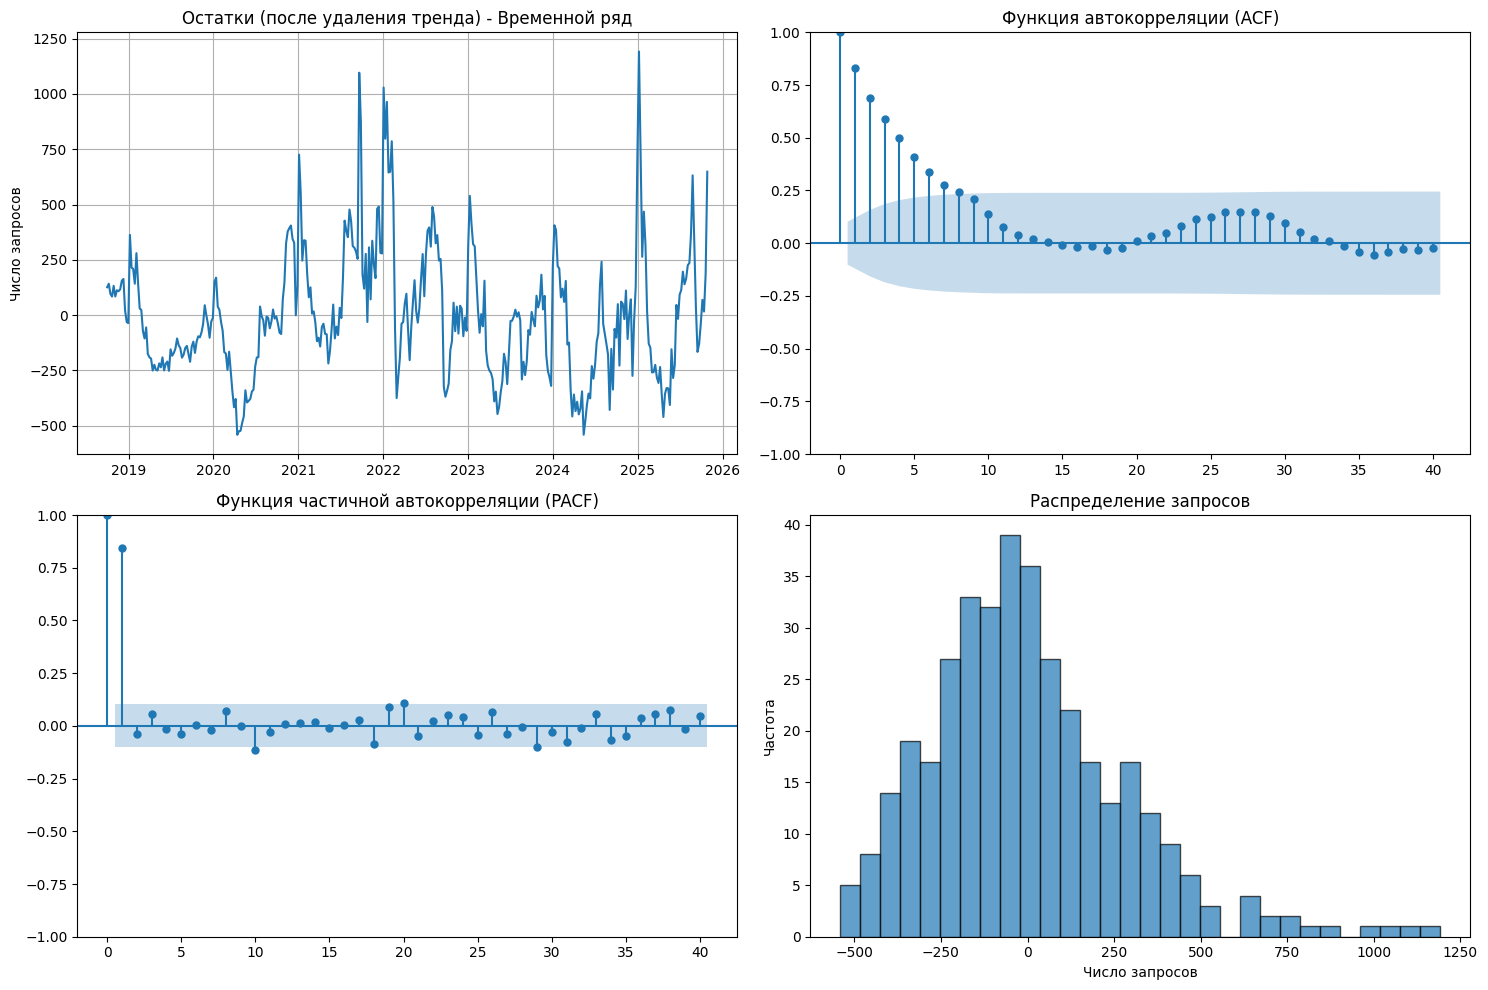

ТЕСТ ДАРБИНА-ВАТСОНА:
   Дарбин-Ватсон: 0.3226 → СИЛЬНАЯ ПОЛОЖИТЕЛЬНАЯ автокорреляция

ТЕСТ ЛЬЮНГА-БОКСА:
   Лаг 5: p-value = 0.000000 → ЕСТЬ автокорреляция ***
   Лаг 10: p-value = 0.000000 → ЕСТЬ автокорреляция ***
   Лаг 20: p-value = 0.000000 → ЕСТЬ автокорреляция ***

КОЭФФИЦИЕНТЫ АВТОКОРРЕЛЯЦИИ:
   Лаг  1:  0.8375
   Лаг  2:  0.6927
   Лаг  3:  0.5917
   Лаг  4:  0.5011
   Лаг  8:  0.2457
   Лаг 12:  0.0416


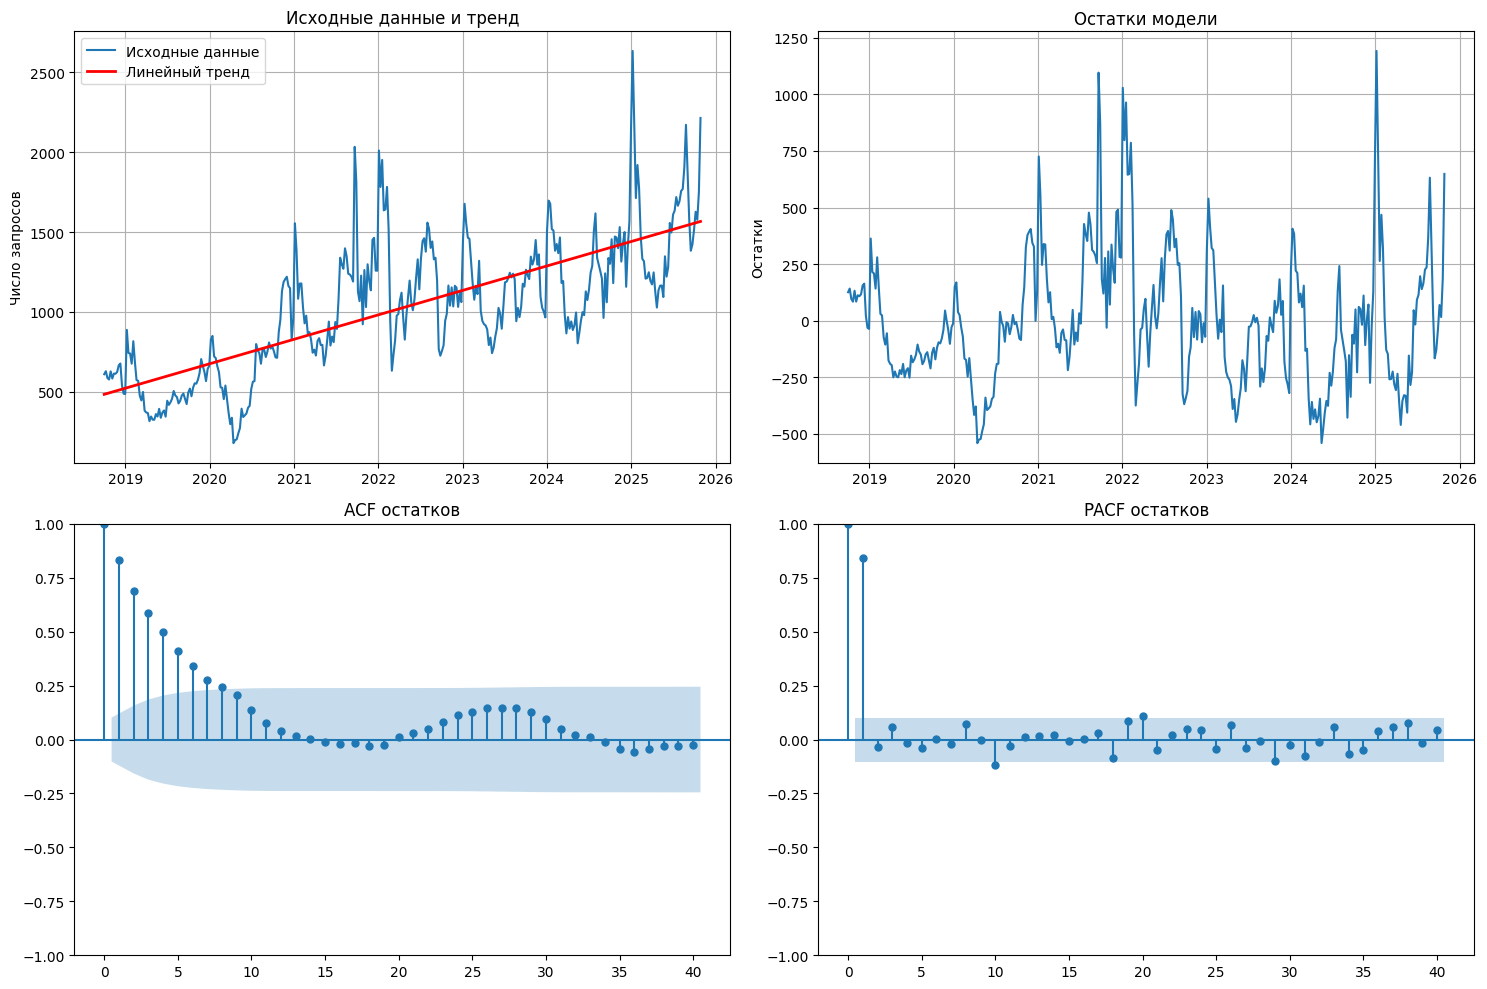

In [ ]:
# Анализ остатков от линейного тренда
print(f"\n{'='*60}")
print("АНАЛИЗ АВТОКОРРЕЛЯЦИИ В ОСТАТКАХ")

# Построим линейную модель для удаления тренда
X = sm.add_constant(np.arange(len(ts_data)))
model = sm.OLS(ts_data, X).fit()
residuals = model.resid

print(f"R² модели: {model.rsquared:.4f}")
print(f"Коэффициент тренда: {model.params.iloc[1]:.4f}")

# Проверим автокорреляцию в остатках
check_autocorrelation(pd.Series(residuals, index=ts_data.index), "Остатки (после удаления тренда)")

# Визуализация тренда и остатков
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(ts_data.index, ts_data.values, label='Исходные данные')
plt.plot(ts_data.index, model.fittedvalues, 'r-', label='Линейный тренд', linewidth=2)
plt.title('Исходные данные и тренд')
plt.ylabel('Число запросов')
plt.legend()
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(ts_data.index, residuals)
plt.title('Остатки модели')
plt.ylabel('Остатки')
plt.grid()

plt.subplot(2, 2, 3)
plot_acf(residuals, lags=40, ax=plt.gca(), alpha=0.05)
plt.title('ACF остатков')

plt.subplot(2, 2, 4)
plot_pacf(residuals, lags=40, ax=plt.gca(), alpha=0.05, method='ols')
plt.title('PACF остатков')

plt.tight_layout()
plt.show()

Остатки гетероскедастичны, поэтому обычным линейным трендом описать данные нельзя. Построим ARIMA-модель

In [ ]:
import itertools
import statsmodels.api as sm

p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))

best_aic = 1e10
best_order = None
best_model = None

for order in pdq:
    try:
        model = sm.tsa.ARIMA(ts_data, order=order).fit()
        if model.aic < best_aic:
            best_aic = model.aic
            best_order = order
            best_model = model
    except:
        pass

print("Лучшая модель:", best_order)
print(best_model.summary())


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Лучшая модель: (1, 1, 1)
                               SARIMAX Results                                
Dep. Variable:               requests   No. Observations:                  370
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2389.782
Date:                Sun, 23 Nov 2025   AIC                           4785.565
Time:                        19:58:34   BIC                           4797.297
Sample:                    10-01-2018   HQIC                          4790.225
                         - 10-27-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8222      0.043     18.902      0.000       0.737       0.907
ma.L1         -0.9590      0.022    -43.847      0.000      -1.002      -0.916
sigma2      2.467e+04    95

In [ ]:
# Добавим сезонность для лучшего результата
model = sm.tsa.SARIMAX(ts_data, order=(1,1,1), seasonal_order=(0,1,0,52)).fit()
print(model.summary())

best_model = model

                                      SARIMAX Results                                      
Dep. Variable:                            requests   No. Observations:                  370
Model:             SARIMAX(1, 1, 1)x(0, 1, [], 52)   Log Likelihood               -2112.290
Date:                             Sun, 23 Nov 2025   AIC                           4230.581
Time:                                     20:08:19   BIC                           4241.857
Sample:                                 10-01-2018   HQIC                          4235.085
                                      - 10-27-2025                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6127      0.057     10.828      0.000       0.502       0.724
ma.L1         -0.9223      

In [ ]:
# Прогноз на полгода вперёд
forecast = best_model.get_forecast(steps=52)
mean_forecast = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

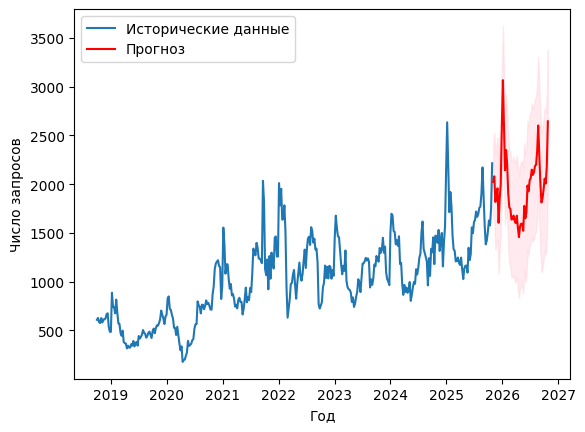

In [ ]:
import matplotlib.pyplot as plt

plt.plot(ts_data, label='Исторические данные')
plt.plot(mean_forecast, label='Прогноз', color='red')
plt.fill_between(confidence_intervals.index,
                 confidence_intervals.iloc[:, 0],
                 confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)
plt.ylabel('Число запросов')
plt.xlabel('Год')
plt.legend()
plt.show()


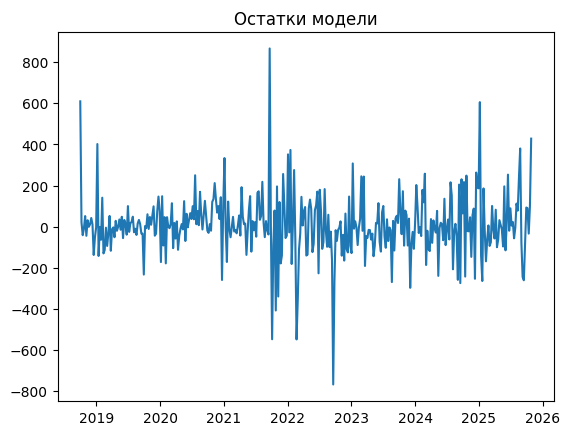

,lb_stat,lb_pvalue
10,8.700646,0.560729


In [ ]:
residuals = best_model.resid
plt.plot(residuals)
plt.title('Остатки модели')
plt.show()

sm.stats.acorr_ljungbox(residuals, lags=[10], return_df=True)

Итого:
1. Есть сезонность
2. Тренд восходящий
3. Автокорреляция присутствует

In [ ]:
!pip install pmdarima


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 7.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
from pmdarima import auto_arima

# Автоматический подбор ARIMA/SARIMA
auto_model = auto_arima(
    ts,
    seasonal=True,
    m=52,
    stepwise=True,
    max_P=1,
    max_Q=1,
    max_order=5,
    trace=True,
)
print(auto_model.summary())
print("Лучшие параметры (p,d,q):", auto_model.order)
print("Лучшие сезонные (P,D,Q,m):", auto_model.seasonal_order)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=inf, Time=25.13 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=4802.713, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=4790.311, Time=4.40 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=4793.685, Time=6.11 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=4800.981, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[52] intercept   : AIC=4803.976, Time=0.05 sec
 ARIMA(1,1,0)(1,0,1)[52] intercept   : AIC=inf, Time=12.95 sec
 ARIMA(1,1,0)(0,0,1)[52] intercept   : AIC=4794.351, Time=3.92 sec
 ARIMA(0,1,0)(1,0,0)[52] intercept   : AIC=4790.389, Time=3.71 sec
 ARIMA(2,1,0)(1,0,0)[52] intercept   : AIC=4784.289, Time=7.90 sec
 ARIMA(2,1,0)(0,0,0)[52] intercept   : AIC=4799.827, Time=0.09 sec
 ARIMA(2,1,0)(1,0,1)[52] intercept   : AIC=inf, Time=17.50 sec
 ARIMA(2,1,0)(0,0,1)[52] intercept   : AIC=4788.839, Time=7.07 sec
 ARIMA(3,1,0)(1,0,0)[52] intercept   : AIC=4785.562, Time=7.84 sec
 ARIMA(2,1,1)(1,0,0)[52] interc